<a href="https://colab.research.google.com/github/JaisSolutions/AgilePractice/blob/main/Abiola%20Oluwole%20Timber_volume_in_Kandri_Kul_seminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture

! pip install rasterio
! pip install geojson
! pip install joblib
! python -m pip install dask[dataframe] --upgrade

In [2]:
import rasterio
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
from rasterio.plot import plotting_extent
from rasterio.mask import mask

import geojson
from shapely.geometry.polygon import Polygon
from shapely import geometry
from osgeo import ogr, osr, gdal
import tifffile as tiff
import csv

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot
import joblib
import dask.dataframe as dd
import glob
import matplotlib.pyplot as plt

In [3]:
# Get the data, unpack it
%%capture
! wget https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/zD03rXLUS-hsvw -O ./bashkiria.zip
! unzip ./bashkiria.zip

## Create dataset

In [4]:
satellite_data = './bashkiria/images/SENTINEL2_2018_06_25.tif'
target_data = './bashkiria/volume.tif'

with rasterio.open(satellite_data) as src:
    band_value = src.read()

with rasterio.open(target_data) as src:
    target_data = src.read()

print(band_value.shape, target_data.shape)

(14, 578, 1267) (1, 578, 1267)


(<Figure size 988.8x604.8 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7e3af794cfd0>)

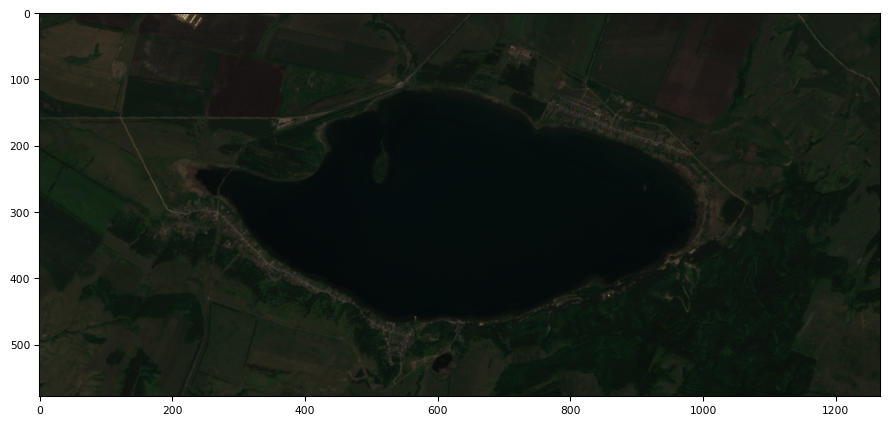

In [5]:
tiff.imshow(np.asarray([band_value[3,:,:], band_value[2,:,:], band_value[1,:,:]]))

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7e3af4cf9db0>)

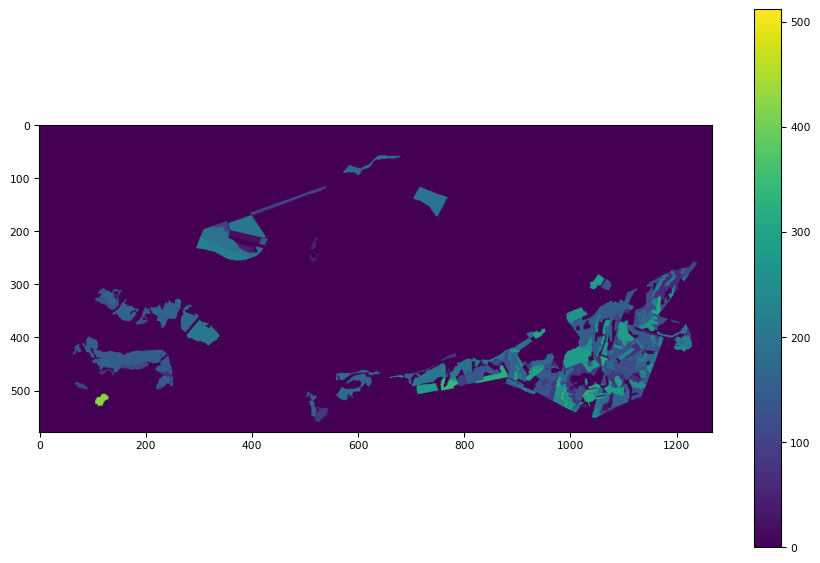

In [6]:
tiff.imshow(target_data)

## Create dataset

Use all labelled pixels

In [7]:
# read file and create tabular data
def create_dataset(satellite_data, tabular_file):
    target_data = './bashkiria/volume.tif' # volume_qgis
    height_data = './bashkiria/height.tif'

    header = ['x', 'y', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08',
            'B8A', 'B09', 'B11', 'B12', 'SCL', 'mask', 'height', 'volume'] # skip B01, SCL, mask
    dataset = []

    input_file = satellite_data
    with rasterio.open(input_file) as src:
        band_value = src.read()

    with rasterio.open(target_data) as src:
        target_values = src.read(1)

    with rasterio.open(height_data) as src:
        height_values = src.read(1)

    #print(band_value.shape, target_values.shape, height_values.shape)

    # skip empty areas
    mask_pixels = target_values > 0
    x_coords, y_coords = np.where(mask_pixels==1)
    dataset.append(x_coords)
    dataset.append(y_coords)

    for ch in range(band_value.shape[0]):
        #dataset.append(band_value[ch][[x_coords, y_coords]])
        dataset.append(band_value[ch][x_coords, y_coords])

    dataset.append(height_values[x_coords, y_coords])
    dataset.append(target_values[x_coords, y_coords])

    dataset = zip(*dataset)
    with open(tabular_file, 'w', encoding='UTF8') as f:
        writer = csv.writer(f)

        # write the header
        writer.writerow(header)

        # write the data
        writer.writerows(dataset)

for date in ['06_25', '07_03', '07_23', '07_25', '08_22']:
    satellite_data = './bashkiria/images/SENTINEL2_2018_{}.tif'.format(date)
    tabular_file = 'dataset_{}.csv'.format(date)
    create_dataset(satellite_data, tabular_file)

In [8]:
# load tabular data
def prepare_dataset(csv_name):
    dataset = pd.read_csv(csv_name, index_col=['x', 'y'], header=0)

    # preprocess
    dataset['ndvi'] = (dataset['B08'] - dataset['B04']) / (dataset['B08'] + dataset['B04'])
    #dataset['ndwi'] = (dataset['B08'] - dataset['B11']) / (dataset['B08'] + dataset['B11'])
    dataset['evi'] = 2.5*(dataset['B08'] - dataset['B04']) / (6*dataset['B08'] - 7.5*dataset['B02']+1)
    dataset['ndre'] = (dataset['B08'] - dataset['B05']) / (dataset['B08'] + dataset['B05'])
    dataset['clr'] = dataset['B07'] / dataset['B05'] - 1

    dataset = dataset[dataset['ndvi'].notna()]
    dataset = dataset[dataset['evi'].notna()]
    dataset = dataset[dataset['ndre'].notna()]

    dataset = dataset.drop(['B01', 'mask', 'SCL'], axis=1)

    print('dataset size: ', len(dataset))

    # split into train and validation
    np.random.seed(0)
    dataset = dataset.iloc[np.random.permutation(len(dataset))] # shuffle
    df_train = dataset[0:int(2*len(dataset)//3)]
    df_test = dataset[int(2*len(dataset)//3):]

    print('train: ', len(df_train), 'test: ', len(df_test))

    # drop target value from features data
    y_train = df_train['volume']
    X_train = df_train.drop(['volume'], axis=1)

    y_test = df_test['volume']
    X_test = df_test.drop(['volume'], axis=1)

    return X_train, y_train, X_test, y_test

Here we merge all five dates into a single dataset. Let's call these data X_train_full and store the target values in y_train_full. The same vectors are created for the test subset.

In [9]:
# create big dataset
# X_train_full, y_train_full, X_test_full, y_test_full = [], [], [], []
# for date in ['06_25', '07_03', '07_25', '08_22', '07_23']:
#     csv_name = 'dataset_{}.csv'.format(date)
#     X_train, y_train, X_test, y_test = prepare_dataset(csv_name)
#     X_train_full.append(X_train)
#     y_train_full.append(y_train)
#     X_test_full.append(X_test)
#     y_test_full.append(y_test)

# X_train_full = pd.concat(X_train_full)
# y_train_full = pd.concat(y_train_full)
# X_test_full = pd.concat(X_test_full)
# y_test_full = pd.concat(y_test_full)

# Data analysis

- create plots and figures that describe the data and support visual data exploration


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import numpy as np
import tifffile as tiff

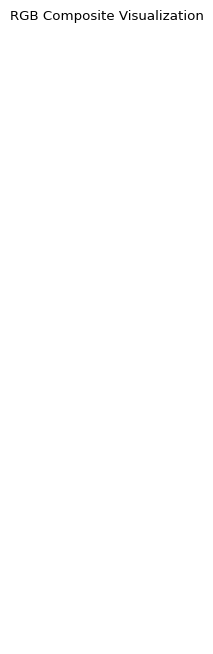

In [40]:
# Visualizing RGB Composite using tifffile
def display_rgb_composite(file, bands=(3, 2, 1)):  # Use bands for RGB visualization
    with tiff.TiffFile(file) as tif:
        image = tif.asarray()
        rgb_image = np.stack([image[b - 1] for b in bands], axis=-1)
    plt.figure(figsize=(10, 8))
    plt.imshow(rgb_image)
    plt.title("RGB Composite Visualization")
    plt.axis('off')
    plt.show()

# Example usage
display_rgb_composite('./bashkiria/images/SENTINEL2_2018_06_25.tif')

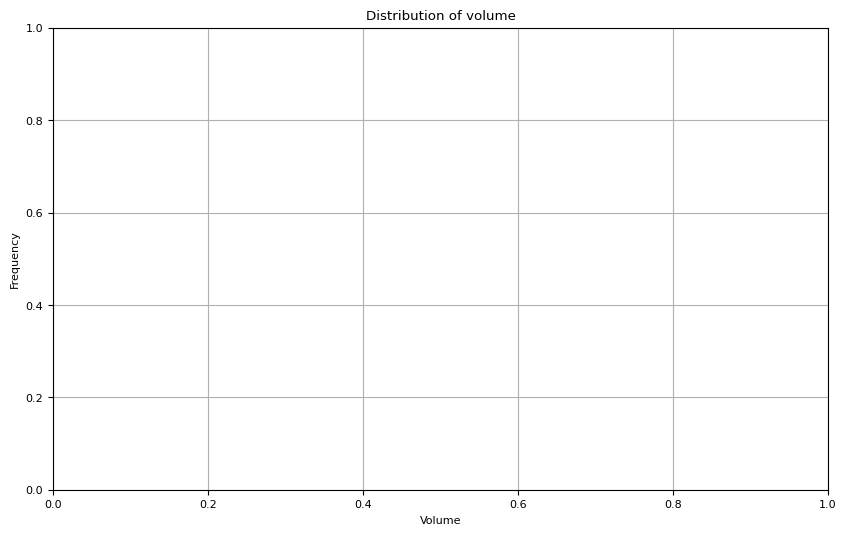

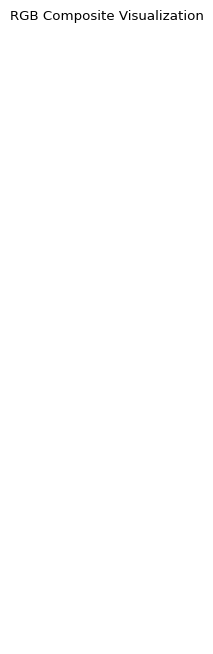

In [50]:
# your code here
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.title('Distribution of volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# Example usage
display_rgb_composite('./bashkiria/images/SENTINEL2_2018_06_25.tif')



In [51]:
def calculate_ndvi(b08, b04):
    return (b08 - b04) / (b08 + b04)

def calculate_evi(b08, b04, b02):
    return 2.5 * (b08 - b04) / (b08 + 6 * b04 - 7.5 * b02 + 1)

# Calculate NDVI
# for stat in ['min', 'max', 'sum', 'mean', 'median', 'std', 'var']:
#     result_df[f'NDVI_{stat}'] = calculate_ndvi(result_df[f'B08_{stat}'], result_df[f'B04_{stat}'])

# # Calculate EVI
# for stat in ['min', 'max', 'sum', 'mean', 'median', 'std', 'var']:
#     result_df[f'EVI_{stat}'] = calculate_evi(result_df[f'B08_{stat}'], result_df[f'B04_{stat}'], result_df[f'B02_{stat}'])

In [57]:
# your code here
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=target_data, x=your_column)
plt.title('Distribution of volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

NameError: name 'your_column' is not defined

<Figure size 1000x600 with 0 Axes>

## Model training

Let's start by training an individual model for each observation date. We have five dates, therefore we should upload csv file for each of these dates and split it into train and test subsets. The results are evaluated based on MAPE, MAE, and R2 metrics.

In [52]:
for date in ['06_25', '07_03', '07_25', '08_22', '07_23']:
    csv_name = 'dataset_{}.csv'.format(date)
    X_train, y_train, X_test, y_test = prepare_dataset(csv_name)

    # your code here for training and validation
    # ML model
    # fit the model
    # make predcition

    print('date: ', date)
    print('MAPE: ', round(mean_absolute_percentage_error(y_test, pred), 3))
    print('MAE: ', round(mean_absolute_error(y_test, pred), 3))
    print('R2', round(r2_score(y_test, pred), 3))
    print('~~~~~~~~~~~~')

dataset size:  70452
train:  46968 test:  23484
date:  06_25


NameError: name 'pred' is not defined

In [ ]:
joblib.dump(model, 'model.pkl')

['rf_model.pkl']

## Save georeferenced predictions for the test region

In [ ]:
# save predictions in tabular data
tabular_file = 'tabular_pred.csv'

predictions = []
predictions.append([item[0] for item in dataset.index.values])
predictions.append([item[1] for item in dataset.index.values])
predictions.append(pred)
predictions = zip(*predictions)
with open(tabular_file, 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    header = ['x', 'y', 'pred']

    # write the header
    writer.writerow(header)

    # write the data
    writer.writerows(predictions)

In [ ]:
# load tabular pred
csv_name = 'tabular_pred.csv'
predictions = pd.read_csv(csv_name, index_col=None, header=0)

In [ ]:
with rasterio.open(satellite_data) as src:
    size_x = src.width
    size_y = src.height
    gt_data = src.read(1)
    pr_data = np.zeros(gt_data.shape)

for ind in range(len(predictions['x'])):
    pr_data[predictions['x'][ind], predictions['y'][ind]] = predictions['pred'][ind]

In [ ]:
# save predictions in georeferenced tif format

# read 'landcover.tif' to get meta data (georeference and pixel size)
with rasterio.open('./VID.tif') as f:
    ras_meta = f.profile
    #img_src = f.read(1)

new_img = pr_data.astype('uint8')

ras_meta['dtype'] = 'uint8'
output_file = 'pred.tif'
with rasterio.open(output_file, 'w', **ras_meta) as dst:
    dst.write(new_img, indexes=1)

## Save prediction for new region

In [ ]:
# preprocess cvs

csv_name = 'dataset_06_25.csv' #'dataset.csv'
dataset = pd.read_csv(csv_name, index_col=['x', 'y'], header=0)

# preprocess
dataset['ndvi'] = (dataset['B08'] - dataset['B04']) / (dataset['B08'] + dataset['B04'])
#dataset['ndwi'] = (dataset['B08'] - dataset['B11']) / (dataset['B08'] + dataset['B11'])
dataset['evi'] = 2.5*(dataset['B08'] - dataset['B04']) / (6*dataset['B08'] - 7.5*dataset['B02']+1)
dataset['ndre'] = (dataset['B08'] - dataset['B05']) / (dataset['B08'] + dataset['B05'])
dataset['clr'] = dataset['B07'] / dataset['B05'] - 1

dataset = dataset[dataset['ndvi'].notna()]
dataset = dataset[dataset['evi'].notna()]
dataset = dataset[dataset['ndre'].notna()]
dataset = dataset.drop(['B01', 'mask', 'SCL', 'volume'], axis=1)

In [ ]:
# load model

clf = joblib.load('model.pkl')

In [ ]:
# create prediction and save it to csv
pred = clf.predict(dataset) #

# save predictions in tabular data
tabular_file = 'tabular_pred.csv'

predictions = []
predictions.append([item[0] for item in dataset.index.values])
predictions.append([item[1] for item in dataset.index.values])
predictions.append(pred)
predictions = zip(*predictions)
with open(tabular_file, 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    header = ['x', 'y', 'pred']

    # write the header
    writer.writerow(header)

    # write the data
    writer.writerows(predictions)

In [ ]:
# load tabular pred
csv_name = 'tabular_pred.csv'
predictions = pd.read_csv(csv_name, index_col=None, header=0)

In [ ]:
# save prediction

with rasterio.open(satellite_data) as src:
    size_x = src.width
    size_y = src.height
    gt_data = src.read(1)
    pr_data = np.zeros(gt_data.shape)

for ind in range(len(predictions['x'])):
    pr_data[predictions['x'][ind], predictions['y'][ind]] = predictions['pred'][ind]

# read satellite image to get meta data (georeference and pixel size)
with rasterio.open(satellite_data) as f:
    ras_meta = f.profile

new_img = pr_data.astype('uint16')

ras_meta['dtype'] = 'uint16'
ras_meta['count'] = 1
output_file = './pred/xgb_all_06_25.tif'
with rasterio.open(output_file, 'w', **ras_meta) as dst:
    dst.write(new_img, indexes=1)

## Calculate CO2 formula

In [ ]:
species = {'aspen': None, 'birch': None, 'spruce': None, 'pine': None, 'lirch': None, 'other': None}
for sp in species:
    with rasterio.open('./{}.tif'.format(sp)) as src:
        size_x = src.width
        size_y = src.height
        species[sp] = src.read(1)

with rasterio.open('./age.tif') as src:
    size_x = src.width
    size_y = src.height
    age = src.read(1)

In [ ]:
species_age = {'aspen': [[0, 20], [20, 30], [30, 40], [40, 1000]],
               'birch': [[0, 20], [20, 40], [40, 50], [50, 1000]],
               'spruce': [[0, 40], [40, 100], [100, 120], [120, 1000]],
               'pine': [[0, 40], [40, 100], [100, 120], [120, 1000]],
               'lirch': [[0, 40], [40, 100], [100, 120], [120, 1000]],
               'other': [[0, 40], [40, 100], [100, 120], [120, 1000]]} # soft

species_coeff = {'aspen': [0.403, 0.426, 0.431, 0.444],
               'birch': [0.524, 0.532, 0.532, 0.527],
               'spruce': [0.398, 0.417, 0.419, 0.424],
               'pine': [0.426, 0.434, 0.440, 0.445],
               'lirch': [0.516, 0.490, 0.486, 0.504],
               'other': [0.601, 0.597, 0.596, 0.608]}

C_content = {'aspen': 0.47, 'birch': 0.47, 'spruce': 0.5, 'pine': 0.5, 'lirch': 0.5, 'other': 0.47}

In [ ]:
BCEF_species = {'aspen': np.zeros(age.shape), 'birch': np.zeros(age.shape), 'spruce': np.zeros(age.shape), 'pine': np.zeros(age.shape), 'lirch': np.zeros(age.shape),'other': np.zeros(age.shape)}
tmp_shape = np.ones(age.shape)

BCEF_species_1 = {'aspen': np.zeros(age.shape), 'birch': np.zeros(age.shape), 'spruce': np.zeros(age.shape), 'pine': np.zeros(age.shape), 'lirch': np.zeros(age.shape), 'other': np.zeros(age.shape)}

for sp in BCEF_species.keys():
    for age_ind in range(4):
        BCEF_species[sp] += np.where((age > species_age[sp][age_ind][0]*tmp_shape) & (age <= species_age[sp][age_ind][1]*tmp_shape), species[sp]*species_coeff[sp][age_ind], 0)
    BCEF_species[sp] *= C_content[sp]

BCEF_final = BCEF_species['aspen'] + BCEF_species['birch'] + BCEF_species['spruce'] + BCEF_species['pine'] + BCEF_species['lirch'] + BCEF_species['other']

In [ ]:
# read satellite image to get meta data (georeference and pixel size)
with rasterio.open(satellite_data) as f:
    ras_meta = f.profile

with rasterio.open('./pred/xgb_all_06_25.tif') as src:
    pr_data = src.read(1)

# formula for CO2
new_img = (pr_data * BCEF_final).astype('float32') #  / 100

ras_meta['dtype'] = 'float32'
ras_meta['count'] = 1
output_file = './pred/carbon_xgb_all_06_25.tif'
with rasterio.open(output_file, 'w', **ras_meta) as dst:
    dst.write(new_img, indexes=1)

In [ ]:
new_img.shape

(578, 1267)

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f05bf67cd90>)

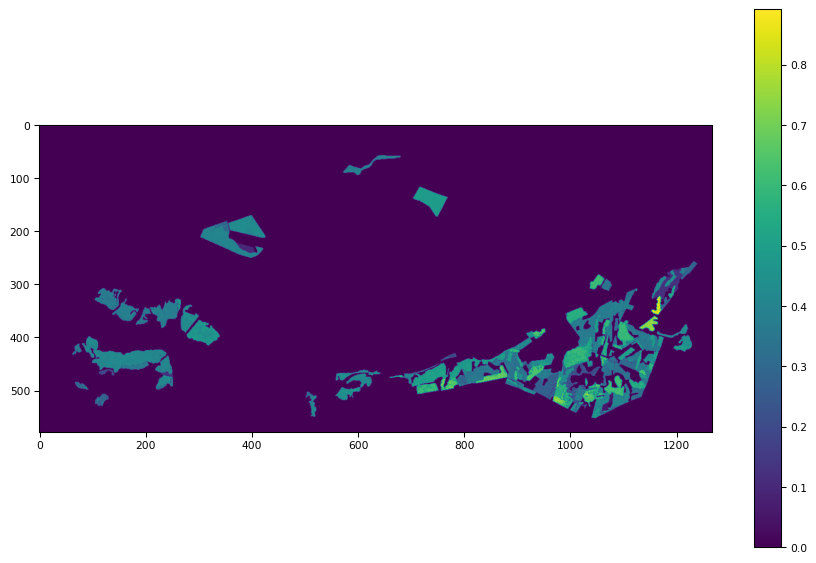

In [ ]:
tiff.imshow(new_img)